In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from sklearn.model_selection import train_test_split
from bart_playground import *

In [3]:
import numpy as np
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
all_sigmas_mtmh = []
all_means_mtmh = []
all_first_pred_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}

for run in range(10):
    bart_mtmh = MultiBART(ndpost=2000, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=run)
    bart_mtmh.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_mtmh.sampler.trace]
    means = [trace.evaluate(X_train).mean() for trace in bart_mtmh.sampler.trace]
    first_preds = [trace.evaluate(X_train[0:1])[0] for trace in bart_mtmh.sampler.trace]
    all_sigmas_mtmh.extend(sigmas)
    all_means_mtmh.extend(means)
    all_first_pred_mtmh.extend(first_preds)

Iterations: 100%|██████████| 2000/2000 [21:57<00:00,  1.52it/s]


In [5]:
all_sigmas_default = []
all_means_default = []
all_first_pred_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}

for run in range(10):
    bart_default = DefaultBART(ndpost=2000, nskip=0, n_trees=100, proposal_probs=proposal_probs, random_state=run)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    means = [trace.evaluate(X_train).mean() for trace in bart_default.sampler.trace]
    first_preds = [trace.evaluate(X_train[0:1])[0] for trace in bart_default.sampler.trace]
    all_sigmas_default.extend(sigmas)
    all_means_default.extend(means)
    all_first_pred_default.extend(first_preds)

Iterations: 100%|██████████| 2000/2000 [02:10<00:00, 15.36it/s]


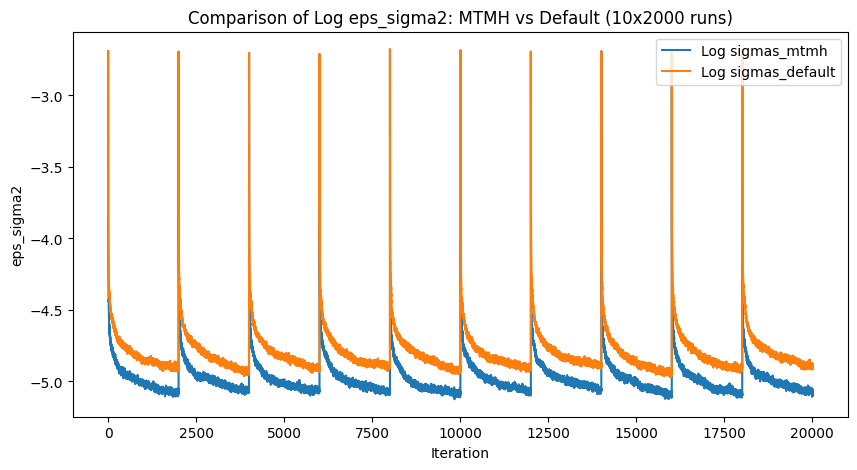

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(np.log(all_sigmas_mtmh), label='Log sigmas_mtmh')
plt.plot(np.log(all_sigmas_default), label='Log sigmas_default')
plt.xlabel('Iteration')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Comparison of Log eps_sigma2: MTMH vs Default (10x2000 runs)')
plt.show()

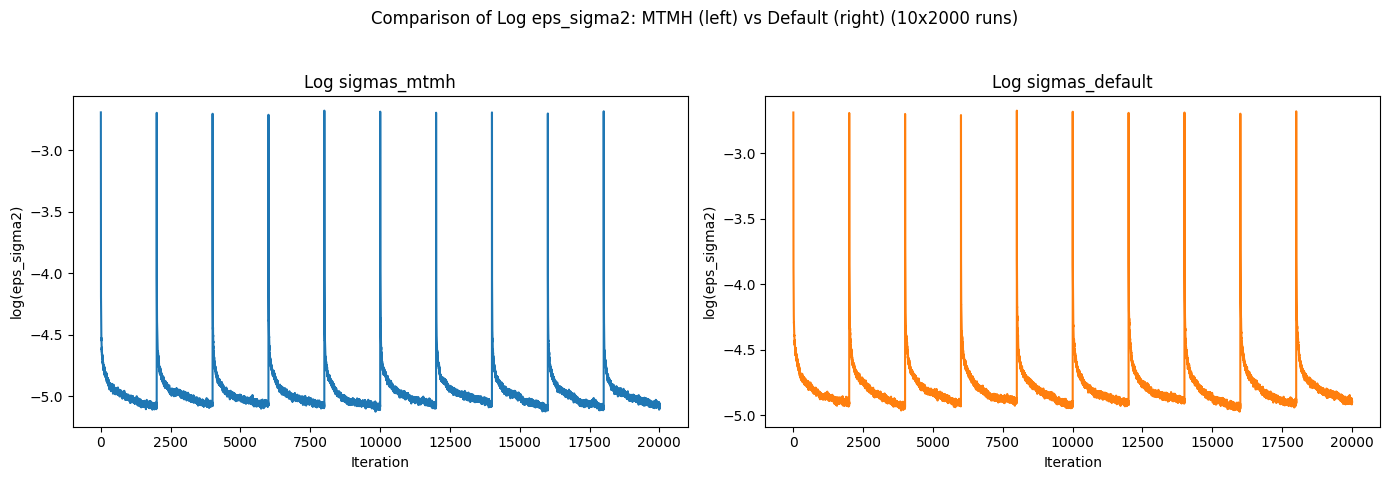

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(np.log(all_sigmas_mtmh), color='tab:blue')
axes[0].set_title('Log sigmas_mtmh')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('log(eps_sigma2)')

axes[1].plot(np.log(all_sigmas_default), color='tab:orange')
axes[1].set_title('Log sigmas_default')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('log(eps_sigma2)')

plt.suptitle('Comparison of Log eps_sigma2: MTMH (left) vs Default (right) (10x2000 runs)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

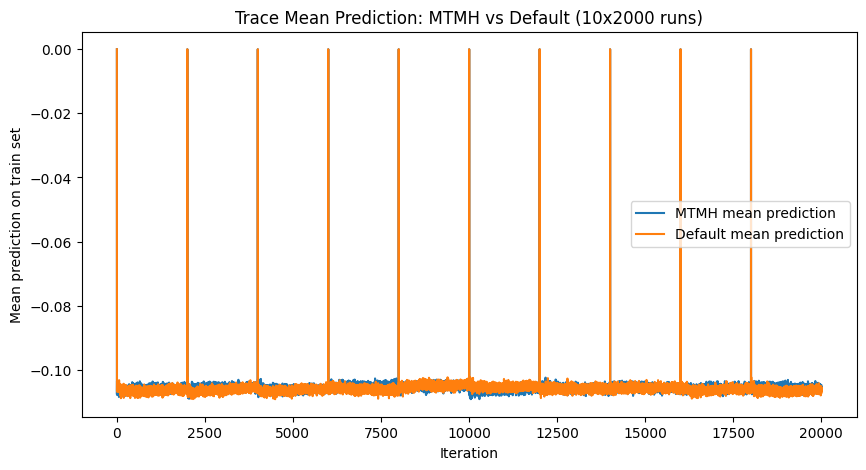

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(all_means_mtmh, label='MTMH mean prediction')
plt.plot(all_means_default, label='Default mean prediction')
plt.xlabel('Iteration')
plt.ylabel('Mean prediction on train set')
plt.legend()
plt.title('Trace Mean Prediction: MTMH vs Default (10x2000 runs)')
plt.show()

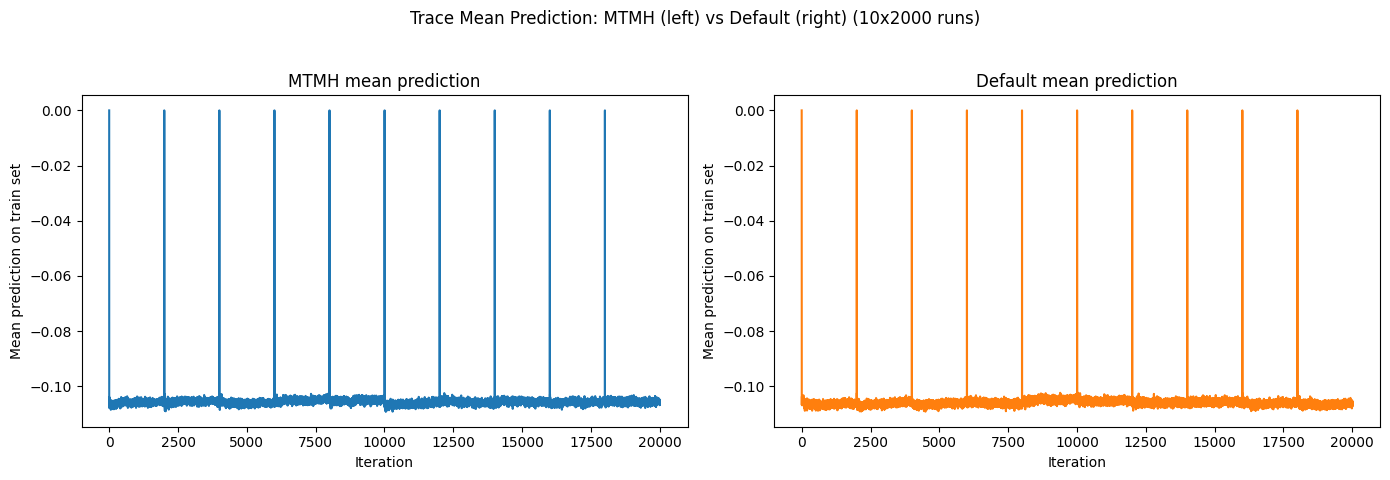

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(all_means_mtmh, color='tab:blue')
axes[0].set_title('MTMH mean prediction')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Mean prediction on train set')

axes[1].plot(all_means_default, color='tab:orange')
axes[1].set_title('Default mean prediction')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean prediction on train set')

plt.suptitle('Trace Mean Prediction: MTMH (left) vs Default (right) (10x2000 runs)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

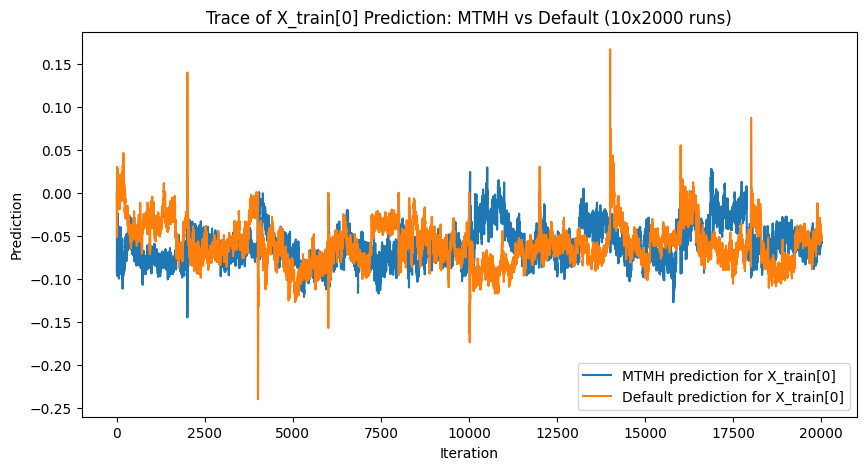

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(all_first_pred_mtmh, label='MTMH prediction for X_train[0]', color='tab:blue')
plt.plot(all_first_pred_default, label='Default prediction for X_train[0]', color='tab:orange')
plt.xlabel('Iteration')
plt.ylabel('Prediction')
plt.legend()
plt.title('Trace of X_train[0] Prediction: MTMH vs Default (10x2000 runs)')
plt.show()

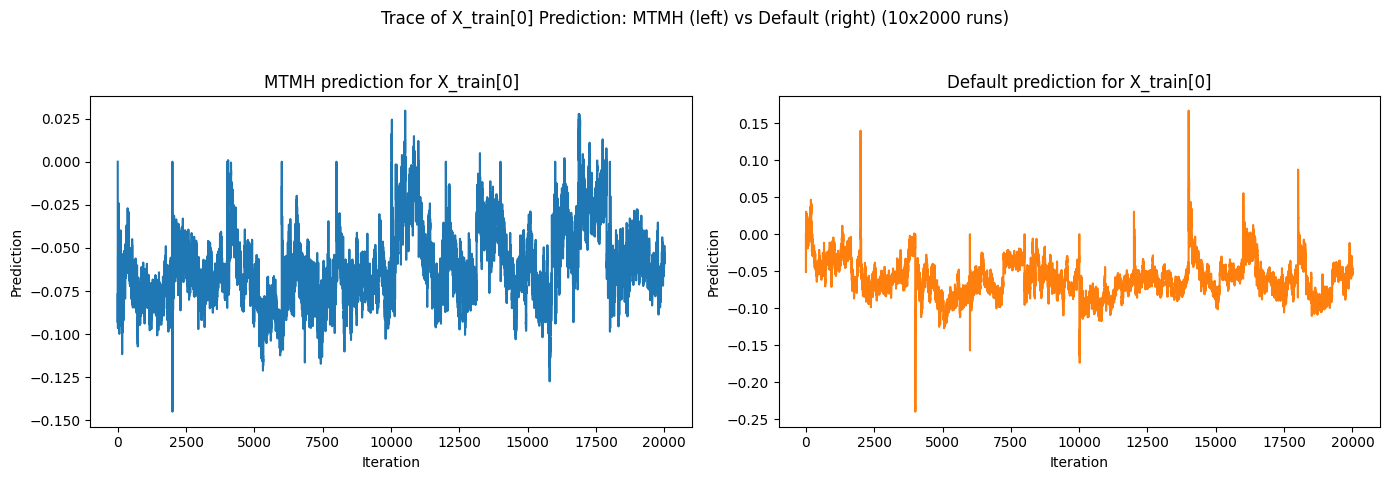

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(all_first_pred_mtmh, color='tab:blue')
axes[0].set_title('MTMH prediction for X_train[0]')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Prediction')

axes[1].plot(all_first_pred_default, color='tab:orange')
axes[1].set_title('Default prediction for X_train[0]')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Prediction')

plt.suptitle('Trace of X_train[0] Prediction: MTMH (left) vs Default (right) (10x2000 runs)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()